# Plotting Library Catalog Subjects

Kaggle has a cool dataset of the Seattle Public Library's catalog. Each item has a list of subjects. For example, the first entry has:

    Musicians Fiction, Bullfighters Fiction, Best friends Fiction, Friendship Fiction, Adventure and adventurers Fiction

Using what I learned in my NLP course last semester, I used one method of building word vectors to make vectors representing library catalog subjects. When I plot them I get something like this:

![](images/2018-05-16-labeled-plot.png)

### Motivation

Natural language processing has techniques for converting words into continuous vector representations: `fish` can be represented with a vector like `[0.2, -0.23, 0.0]`. These sometimes contain interesting information (e.g. ["king - man + woman = queen"](http://p.migdal.pl/2017/01/06/king-man-woman-queen-why.html)). 

I can use one of those techniques to come up with vectors representing library catalog subjects.

Primarily I wanted to use the vectors to plot the library book subjects. I'm curious if I'd see a dimension representing the "children's books - young adult - grown up", or if science subjects cluster together.

Word vectors are also useful in Information Retrieval. With a vector representation, I can use math to measure how similar two subjects are. For example, if I'm searching the catalog for "Friendship Fiction", I wouldn't mind also seeing "Best friends Fiction" books that are missing the "Friendship Fiction" label. Subject vectors could help.

Word vectors are also used in more complex NLP models like neural machine translation.
The way I think of this is that if I can tell the model that "Best friends Fiction" and "Friendship Fiction" are related in a specific way, then when the model learns about "Best friends Fiction", it can also improve predictions for "Friendship Fiction."

### Vector representations

In NLP-land, "distributional methods" assume that "Words that occur in similar contexts tend to have similar meanings" (from [Jurafsky and Martin's textbook](http://web.stanford.edu/~jurafsky/slp3/15.pdf)). I think distributional methods would make interesting representations of library catalog subjects.
One way to turn this into word vectors is to make sparse vectors of metrics based on co-occurring words, and then reduce the number of dimensions to get a dense vector.


### Plan

Using this assumption with library catalog subjects, I can describe "Musicians Fiction" with the subjects "Bullfighters Fiction", "Best friends Fiction", and so on. Specifically, I'll go through all catalog entries that contain "Musicians Fiction" and count up how many times each other subject shows up. This will give me a huge vector of counts like:

     Musicians Fiction:   0 1 4 0 ... 150K other numbers, mostly 0s ... 1 0 1 0

I could store this in a big `Number of subjects x Number of subjects` matrix, but it turns out there are a lot of subjects (~150K)! Because of computational limitations, I'll define a subset of subjects containing the "interesting" subjects (~1000), and only compute dense vectors for these. This means I'll use a matrix of size `Number of interesting subjects x Number of subjects` (1000 x 150K). By doing it this way, I'll still use the rarer subjects when coming up with the dense vectors of the interesting subjects.

Raw co-occurrence counts and relative frequencies have some issues. For word vectors, one problem is that words like "the" occur with all subjects equally (or for library catalog subject vectors, maybe "Large print books" co-occur with many other subjects). These subjects don't provide more information about the interesting subjects. So instead of using the counts directly, I'll use PPMI, which is higher if the words co-occur more often than chance. It is a function of the co-occurrence counts and global counts.

At this point, I'll have sparse vectors of length `Number of subjects` (~150K) that represent each of my interesting subjects. I'll use PCA to reduce the number of dimensions. Dimensionality reduction is really cool! By reducing the number of dimensions in a clever way, the vector might represent higher-order co-occurrence. [Here's a post on reducing dimensions using SVD](2018-05-16-SVD-demo.ipynb).

This was a quick introduction to dense vectors. Check out [Vector Semantics](https://web.stanford.edu/~jurafsky/slp3/15.pdf) and [Semantics with Dense Vectors](https://web.stanford.edu/~jurafsky/slp3/16.pdf) for details!

## Preprocessing

In [1]:
# imports and helper functions you can skip over :D
import csv
from collections import defaultdict
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.sparse as sp
from scipy.sparse.linalg import svds

SAVE = True
def maybe_save_plot(filename):
    if SAVE:
        plt.tight_layout()
        plt.savefig('images/' + filename, bbox_inches="tight")

### Data

I got this data from [Kaggle](http://kaggle.com/seattle-public-library), though it's also available at [data.seattle.gov](https://data.seattle.gov/Community/Checkouts-by-Title/tmmm-ytt6). I have it downloaded and unzipped locally in the `data` folder. 

In [2]:
LOCATION = 'data/seattle-library-checkout-records/'
file_path = os.path.join(LOCATION, 'Library_Collection_Inventory.csv')

Here's what a line of the `Library_Collection_Inventory.csv` file contains:

In [3]:
# print the first entry
with open(file_path, 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    print('\n'.join(map(str, next(reader).items())))

('BibNum', '3011076')
('Title', "A tale of two friends / adapted by Ellie O'Ryan ; illustrated by Tom Caulfield, Frederick Gardner, Megan Petasky, and Allen Tam.")
('Author', "O'Ryan, Ellie")
('ISBN', '1481425730, 1481425749, 9781481425735, 9781481425742')
('PublicationYear', '2014.')
('Publisher', 'Simon Spotlight,')
('Subjects', 'Musicians Fiction, Bullfighters Fiction, Best friends Fiction, Friendship Fiction, Adventure and adventurers Fiction')
('ItemType', 'jcbk')
('ItemCollection', 'ncrdr')
('FloatingItem', 'Floating')
('ItemLocation', 'qna')
('ReportDate', '09/01/2017')
('ItemCount', '1')


    ('BibNum', '3011076')
    ('Title', "A tale of two friends / adapted by Ellie O'Ryan ; illustrated by Tom Caulfield, Frederick Gardner, Megan Petasky, and Allen Tam.")
    ('Author', "O'Ryan, Ellie")
    ('ISBN', '1481425730, 1481425749, 9781481425735, 9781481425742')
    ('PublicationYear', '2014.')
    ('Publisher', 'Simon Spotlight,')
    ('Subjects', 'Musicians Fiction, Bullfighters Fiction, Best friends Fiction, Friendship Fiction, Adventure and adventurers Fiction')
    ('ItemType', 'jcbk')
    ('ItemCollection', 'ncrdr')
    ('FloatingItem', 'Floating')
    ('ItemLocation', 'qna')
    ('ReportDate', '09/01/2017')
    ('ItemCount', '1')

### Preprocessing

I'll start by getting the list of subjects out of the file and perform a little preprocessing.

First, I'll drop items without subjects. Then I'll work with lowercase strings.

Then I'll remove duplicates. If I have duplicate items with the same subjects, I'll overestimate how closely two subjects are related. A complication is that the `Title` field alone isn't enough to detect duplicates. For example, here are a few `Title` fields for "Crime and Punishment":

    Crime and punishment / Fyodor Dostoyevsky ; translated with an introduction and notes by Oliver Ready.
    Crime and punishment / Fyodor Dostoevsky ; translated from the Russian by Richard Pevear and Larissa Volokhonsky
    Crime and punishment / Fyodor Dostoyevsky ; translated with an introduction and notes by David McDuff.
    Crime and punishment / Fyodor Dostoyevsky ; translated with an introduction and notes by David McDuff.
    Crime and punishment / Fyodor Dostoyevsky ; translated with an introduction and notes by David McDuff.
        
A naive way to mitigate this is to count an item as unique if it has the same title (the text before the `/` in the `Title` field) and author (from the `Author` field), and take the union of all duplicate entries' subjects.

In [4]:
items_to_subjects = defaultdict(set)

def clean_text(text):
    return text.strip().lower()

def normalize_item(item):
    # TODO: The library system has multiple copies of the same book. 
    # This catches a few books with exactly the same title/author, because
    # otherwise I'll overcount their subjects' co-occurrences. But this approach
    # can be improved!
    title = item['Title'].split('/')[0]  # The stuff before '/' looks like the title
    return (
        clean_text(title),
        clean_text(item['Author']),
    )

with open(file_path, 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    for i, item in enumerate(reader):
        subjects = [
            clean_text(item)
            for item in item['Subjects'].split(', ')
        ]
        
        # Drop items without subjects!
        if not subjects:
            continue
            
        # normalize the item
        item_info = normalize_item(item)
        
        items_to_subjects[item_info].update(subjects)

### Pandas

Now I'll expand `items_to_subjects` into a list of `item-subject` pairs and make a `pandas` DataFrame from it. I just use `pandas` to make it a little easier to compute counts.

In [5]:
all_item_subject_pairs_df = pd.DataFrame(
    [
        (item, subject)
        for item, subjects in items_to_subjects.items()
        for subject in subjects
    ], 
    columns=['Item', 'Subject']
)

In [6]:
all_item_subject_pairs_df.head()

,Item,Subject
0,"(a tale of two friends, o'ryan, ellie)",musicians fiction
1,"(a tale of two friends, o'ryan, ellie)",bullfighters fiction
2,"(a tale of two friends, o'ryan, ellie)",best friends fiction
3,"(a tale of two friends, o'ryan, ellie)",friendship fiction
4,"(a tale of two friends, o'ryan, ellie)",adventure and adventurers fiction


### Stats

Now I can check out a few stats. There are around 450K subjects. 303K subjects occur for only one book, including `bridges northwest pacific juvenile fiction` and `cicindela speciation`.

In [7]:
print('total items:', len(all_item_subject_pairs_df))
print('total unique subjects:', len(all_item_subject_pairs_df.groupby('Subject')))
print('total unique items:', len(all_item_subject_pairs_df.groupby('Item')))
print()
print('subjects with one book:', sum(all_item_subject_pairs_df['Subject'].value_counts() == 1))

total items: 1817414
total unique subjects: 450371
total unique items: 563868

subjects with one book: 303239


### Removing subjects with only one item

Subjects that only occur once aren't going to give much information about other subjects, so I'll filter them out.
This gives me around 150K subjects.

In [8]:
item_subject_pairs_df = all_item_subject_pairs_df.groupby('Subject').filter(lambda x: len(x) > 1)

In [9]:
print('total unique subjects:', len(item_subject_pairs_df.groupby('Subject')))
print('subjects with one book (should be 0):', sum(item_subject_pairs_df['Subject'].value_counts() == 1))

total unique subjects: 147132
subjects with one book (should be 0): 0


## Mappings

### Subject to index mappings

First I need to map each subject to an index for the `Number of subjects` dimension. To do this I'll have a way to convert an index into a subject and a subject into an index.

In [10]:
index_to_other_subject = item_subject_pairs_df['Subject'].unique()

other_subject_to_index = {
    subject: i
    for i, subject in enumerate(index_to_other_subject)
}

### "Interesting" subjects

To make things run a little faster, I'll also define a set of subjects as the ones I'll want to plot.
I'll use subjects that occur at least 100 times.

In [11]:
INTERESTING_SUBJECT_COUNT_CUTOFF = 100

index_to_interesting_subject = item_subject_pairs_df.groupby('Subject').filter(
    lambda x: len(x) > INTERESTING_SUBJECT_COUNT_CUTOFF
)['Subject'].unique()

interesting_subject_to_index = {
    subject: i
    for i, subject in enumerate(index_to_interesting_subject)
}

### Subject counts

To compute PPMI, I'll also need the number of overall subject counts.

In [12]:
subject_to_count = dict(item_subject_pairs_df['Subject'].value_counts())

## Sparse Matrix



Now I want to load this into a subject-subject matrix of size the `Number of _interesting_ subjects x Number of subjects` matrix. Each row will represent the "interesting" subjects and columns that represent information I know about those subjects, in this case, the PPMI on co-occurring subjects.

PPMI is given by 

$$PPMI(w_i, w_j) =  \max\left(\log\left( \frac{n \,\times\, \text{count of co-occurrences of }w_i\text{ and }w_j}{\text{count of } w_i  \, \times \, \text{count of } w_j}\right), 0\right).$$

If you're interested in more information about PPMI and what I'm up to, 
check out Vector Semantics and Semantics with Dense Vectors in [Speech and Language Processing](http://web.stanford.edu/~jurafsky/slp3/). Specifically: "Weighing terms: Pointwise Mutual Information (PMI)", currently in section 15.2.

Because this matrix would have 255,000,000 elements, I use `scipy`'s sparse matrices. I use the `coo_matrix`, which is supposed to be good for constructing sparse matrices, and then convert it to a `csr_matrix`, which supports arithmetic operations.

In [13]:
def word_word_sparse_from_data(
    item_to_subjects,
    subject_to_count, 
    interesting_subject_to_index,
    other_subject_to_index,
):
    '''Build a sparse matrix of the subject-subject co-occurrence PPMI's
    
    returns:  a sparse matrix with size `Number of interesting subjects` x `Number of subjects`
    '''
    # First count how many times subjects d
    # This builds a dictionary that maps an (interesting_subject, other_subject) to a count of co-occurrences.
    # The interesting_subject should be in the interesting_subject list defined above (i.e. filter out non-interesting)
    # The other_subject should be in the (almost) full list of words (i.e. remove words we filtered from other_subject_to_index)
    counts = defaultdict(int)
    for title, subjects in item_to_subjects.items():
        for interesting_subject in subjects:
            # the interesting subject should be in the interesting subjects list
            if interesting_subject not in interesting_subject_to_index:
                continue
            for other_subject in subjects:
                # The other subject should not be the same as the main one
                if interesting_subject == other_subject:
                    continue                
                # The other subject needs to be in the larger subject list (occurring at least once)
                if other_subject not in other_subject_to_index:
                    continue
                counts[(interesting_subject, other_subject)] += 1

    total = sum(subject_to_count.values())
     
    # build the three lists I need for the `sp.coo_matrix` call.
    interesting_subject_ids = []
    other_subject_ids = []
    count_ids = []
        
    for (interesting_subject, other_subject), count in counts.items():
        c_i = subject_to_count[interesting_subject]
        c_j = subject_to_count[other_subject]
        
        # PPMI
        new_count = np.max(np.log(total * count/(c_i * c_j)), 0)
        
        # Find these subjects' indices
        interesting_subject_ids.append(interesting_subject_to_index[interesting_subject])
        other_subject_ids.append(other_subject_to_index[other_subject])
        count_ids.append(new_count)
    
    # Build a sparse matrix from these lists
    sparse_word_word = sp.coo_matrix((
        count_ids, 
        (interesting_subject_ids, other_subject_ids)
    )).astype(float)
    return sparse_word_word.tocsr()

sparse_word_word = word_word_sparse_from_data(
    items_to_subjects, 
    subject_to_count, 
    interesting_subject_to_index,
    other_subject_to_index,
)

## Looking at `sparse_word_word`

Using this I could see whether  `political fiction` and `satirical literature` co-occur more or less likely than you'd expect according to its PPMI. In this case, it's `5.281`, so they occur together pretty often!

Compare this with the PPMI of `political fiction` and `alphabet` books. This gets a 0 because they co-occurred less frequently than you'd expect.

In [14]:
def ppmi_for_subjs(subj1, subj2):
    print('PPMI for `{}` and `{}`: {:.3f}'.format(
        subj1,
        subj2,
        sparse_word_word[interesting_subject_to_index[subj1], other_subject_to_index[subj2]]
    ))

ppmi_for_subjs('political fiction', 'satirical literature')
ppmi_for_subjs('political fiction', 'alphabet')

PPMI for `political fiction` and `satirical literature`: 5.281
PPMI for `political fiction` and `alphabet`: 0.000


## Reducing dimensions

Now I can use SVD to reduce the number of dimensions. Since I'm just going to plot the points, I'll just reduce it to four dimensions.

In [15]:
def dense_vecs_from_sparse(sparse_matrix, dimensions):
    # center the matrix
    sparse_matrix = sparse_matrix - np.mean(sparse_matrix, axis=0)
    u, s, v = svds(sparse_matrix, k=dimensions)

    return u

In [16]:
dimensions = 4

vecs = dense_vecs_from_sparse(
    sparse_word_word, 
    dimensions=dimensions, 
)

### Visualizing

Let's try to visualize these points in 4-space! 
I'll draw pairwise plots for each pair of dimensions. I'll also mark the same point, in this case 'documentary film', in all graphs.

In [17]:
def plot_in_4d(axes, four_dim_vec, plot_args=None, plot_kwargs=None, label=''):
    plot_args = plot_args or ['.']
    plot_kwargs = plot_kwargs or {}
    for i in range(3):
        for j in range(i + 1, 4):
            axes[j - 1, i].plot(four_dim_vec[:, i], four_dim_vec[:, j], *plot_args, **plot_kwargs)
                        
        for j in range(0, i):
            axes[j, i].axis('off')

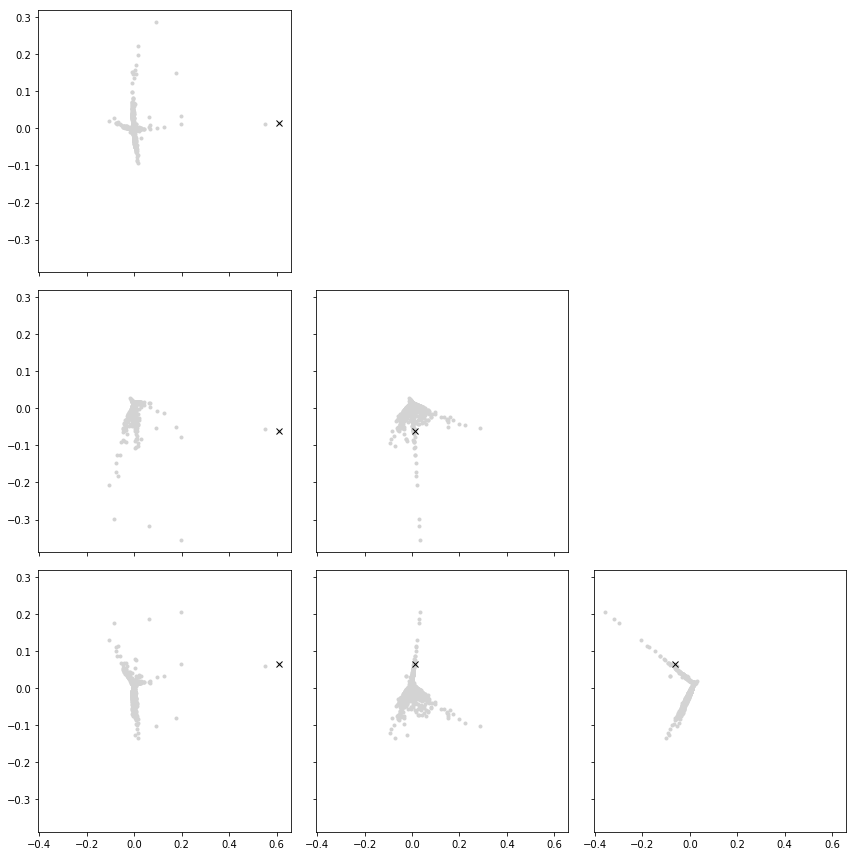

In [18]:
topic = 'documentary films'
vec = vecs[interesting_subject_to_index[topic], None]

fig, axes = plt.subplots(3, 3, figsize=(12, 12), sharex=True, sharey=True)

plot_in_4d(axes, vecs, plot_kwargs={'color': 'lightgray'})
plot_in_4d(axes, vec, plot_args=['xk'], label=topic)

maybe_save_plot('2018-05-16-4d-plot')
plt.show()

I haven't sorted out why points like `documentary films` are so far away. I've seen suggestions that I should make the original data have unit variance. I didn't do it this time around because it seems trickier with the `sparse` matrices.

### Highlighting a few points

This is fun to explore! Here I plot a few different subjects. There seems to be one dimension for films, books, ending in a little corner for graphic novels and comic books. The other dimension stretches from children's books to other fiction to mystery and thriller books.

Next, I can take one view and highlight a few different subjects.

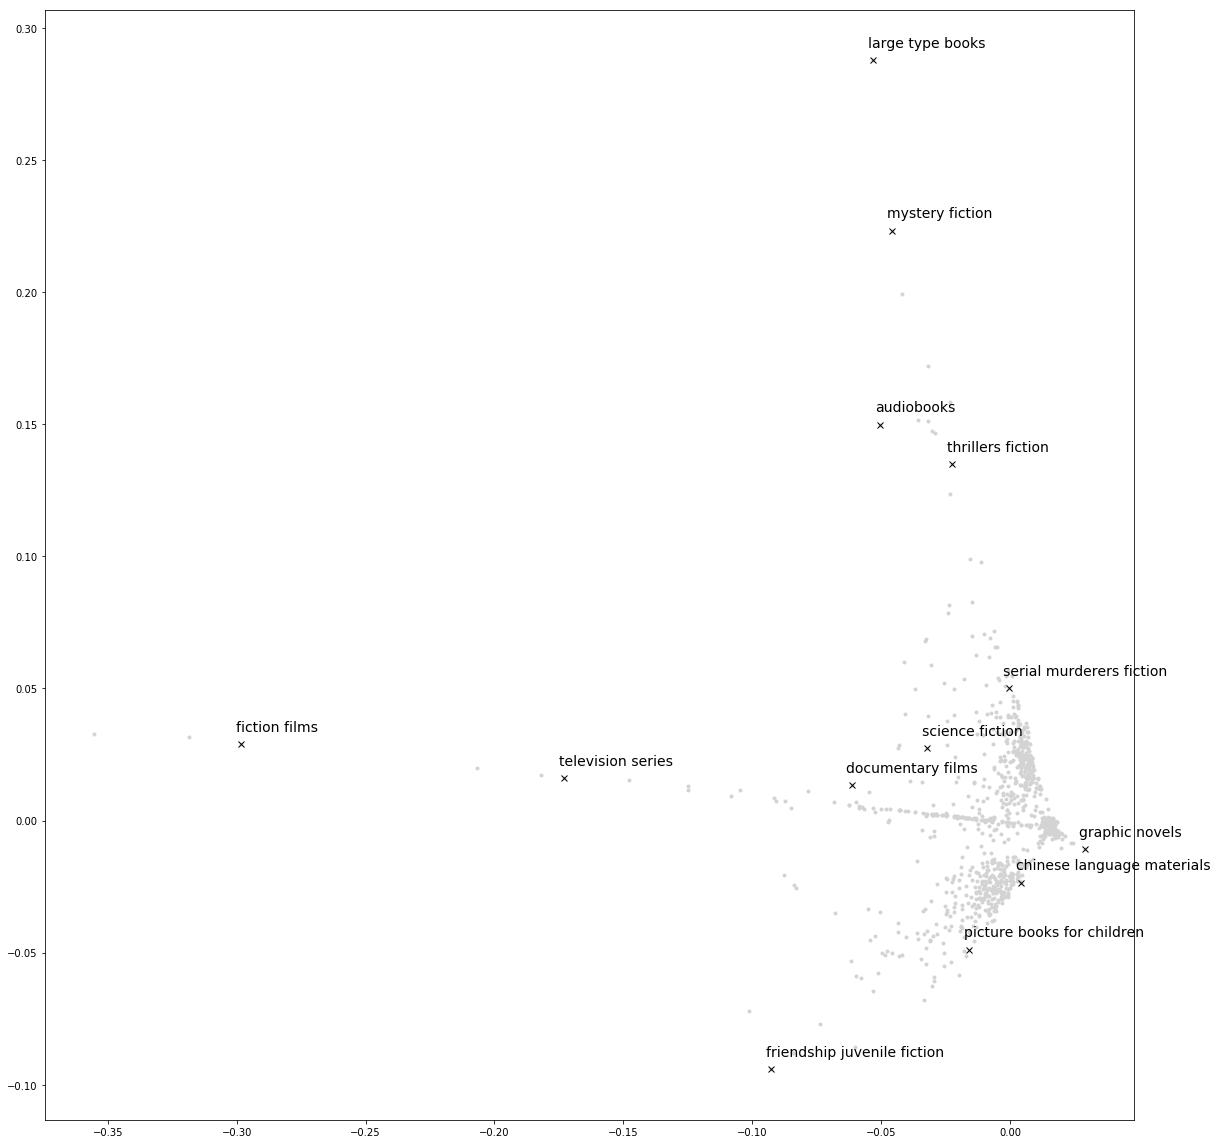

In [19]:
fun_topics = [
    'documentary films',
    'fiction films',
    'mystery fiction',
    'thrillers fiction',
    'audiobooks',
    'friendship juvenile fiction',
    'graphic novels',
    'science fiction',
    'large type books',
    'television series',
    'chinese language materials',
    'picture books for children',
    'serial murderers fiction',
]

fig, axes = plt.subplots(1, 1, figsize=(16, 16), sharex=True, sharey=True)

x_dim = 2
y_dim = 1

axes.plot(vecs[:, x_dim], vecs[:, y_dim], '.', color='lightgray')

for topic in fun_topics:
    x = vecs[interesting_subject_to_index[topic], x_dim]
    y = vecs[interesting_subject_to_index[topic], y_dim]    
    axes.plot(x, y, 'xk')
    axes.annotate(topic, (x - 0.002, y + 0.005), fontsize=14)

maybe_save_plot('2018-05-16-labeled-plot')
plt.show()

### Interactive

I also tried making an interactive plot using `bokeh`. This is a little funky for now, but I'm posting it because it's really fun.

In [20]:
from bokeh.models import HoverTool
from bokeh.plotting import figure, show, output_file, ColumnDataSource
from bokeh.layouts import gridplot
from bokeh.palettes import magma

def plot(u, x_dim='x1', y_dim='x2', descs=index_to_interesting_subject):

    source = ColumnDataSource(data=dict(
        x1=u[:, 0],
        x2=u[:, 1],
        x3=u[:, 2],
        x4=u[:, 3],
        desc=descs,
    ))

    hover = HoverTool(tooltips=[
        ("index", "$index"),
        ("desc", "@desc"),
    ])

    p = figure(plot_width=800, plot_height=800, tools=[hover, 'zoom_in', 'pan', 'zoom_out'])
    p.scatter(
        x_dim, y_dim,
        size=5,
        source=source,
        line_color=None,
        alpha=0.8,
    )

    grid = gridplot([[p]])

    output_file("2018_05_16_library_catalog_subjects_{}_{}.html".format(x_dim, y_dim), title="Library Catalog Subjects")
    
    show(grid)

plot(vecs, 'x1', 'x2')

## See Also

 - This data is also available on [data.seattle.gov](https://data.seattle.gov/Community/Checkouts-by-Title/tmmm-ytt6), which tells me that I should say:
> "The data made available here has been modified for use from its original source, which is the City of Seattle. Neither the City of Seattle nor the Office of the Chief Technology Officer (OCTO) makes any claims as to the completeness, timeliness, accuracy or content of any data contained in this application; makes any representation of any kind, including, but not limited to, warranty of the accuracy or fitness for a particular use; nor are any such warranties to be implied or inferred with respect to the information or data furnished herein. The data is subject to change as modifications and updates are complete. It is understood that the information contained in the web feed is being used at one's own risk."

 - I found it via [kaggle](https://www.kaggle.com/seattle-public-library/seattle-library-checkout-records)